# 5. Text Detection, Recognition & Spotting on the CCPD 2019 Dataset


In this notebook, we will be learning how the text detection, recognition, and spotting tasks are done on the [Chinese City Parking Dataset](https://github.com/detectRecog/CCPD) using [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR). We will first install and import necessary libraries and then define commonly used functions for creating models, inferencing images, and evaluating results. Lastly, besides assessing the results of pre-trained models, we will look at the steps to perform fine-tuning and the respective results.

**Table of Contents**

1. [Mount Google Drive](#mount-google-drive)
2. [Install PaddleOCR](#install-paddleocr)
3. [Define Commonly Used Functions](#define-commonly-used-functions)
4. [Evaluate with Pre-trained Models](#evaluated-with-pre-trained-models)
5. [Evaluate with Fine-tuned Models](#evaluate-with-fine-tuned-models)
6. [Pre-trained vs Fine-tuned Models](#pre-trained-vs-fine-tuned-models)
7. [Conclusion](#conclusion)

Get your seatbelt on and let's get started! 🔥⭐


<a name="mount-google-drive"></a>
## Mount Google Drive


In [1]:
from google.colab import drive

drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"
%cd "CCPD2019"
!ls

/content/drive/My Drive
/content/drive/My Drive/CCPD2019
CCPD2019      condacolab_install.log  train_crop     train.txt	val_crop     val.txt
CCPD2019.zip  train		      train_rec.txt  val	val_rec.txt


<a name="install-paddleocr"></a>
## Install PaddleOCR


In [3]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/"
!git clone --single-branch --branch release/2.6 https://github.com/PaddlePaddle/PaddleOCR.git
%cd ./PaddleOCR
!pip install shapely==2.0.7
!pip install scikit-image==0.25.2
!pip install imgaug==0.4.0
!pip install tqdm==4.67.1
!pip install visualdl
!pip install RapidFuzz==3.12.2
!pip install opencv-python==4.6.0.66
!pip install opencv-contrib-python==4.6.0.66
!pip install Cython==3.0.12
!pip install lxml==5.3.1
!pip install openpyxl==3.1.5
!pip install lanms-neo==1.0.2
!pip install python-bidi==0.6.3
!pip install levenshtein==0.21.0
!pip install Polygon3==3.0.9.1
!pip install lanms-nova==1.0.3
!pip install pyclipper==1.3.0.post6
!pip install lmdb==1.6.2
!pip install paddlepaddle==2.5.2
!pip install numpy==1.26.3

/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition
fatal: destination path 'PaddleOCR' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/PaddleOCR


** **If this is running on Google Colab, before running the rest, press Runtime > Restart session.**

In [4]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east"
!rm -rf *.tar*
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_mv3_east_v2.0_train.tar
!tar xvf det_mv3_east_v2.0_train.tar

%cd "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn"
!rm -rf *.tar*
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/rec_mv3_none_bilstm_ctc_v2.0_train.tar
!tar xvf rec_mv3_none_bilstm_ctc_v2.0_train.tar


/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east
--2025-03-25 09:05:05--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_mv3_east_v2.0_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.47.176, 2402:2b40:7000:628:0:ff:b0e8:88da
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33679360 (32M) [application/x-tar]
Saving to: ‘det_mv3_east_v2.0_train.tar’

det_mv3_east_v2.0_t 100%[===================>]  32.12M  8.45MB/s    in 20s     

2025-03-25 09:05:27 (1.61 MB/s) - ‘det_mv3_east_v2.0_train.tar’ saved [33679360/33679360]

det_mv3_east_v2.0_train/
det_mv3_east_v2.0_train/best_accuracy.pdparams
det_mv3_east_v2.0_train/best_accuracy.states
det_mv3_east_v2.0_train/best_accuracy.pdopt
det_mv3_east_v2.0_train/train.log
/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn
--2025-03-25 09

<a name="define-commonly-used-functions"></a>
## Define Commonly Used Functions


In [5]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/PaddleOCR"
!ls

/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/PaddleOCR
applications  deploy	   LICENSE	 ppocr	      README_ch.md	setup.py   tools
benchmark     doc	   MANIFEST.in	 PPOCRLabel   README.md		StyleText  train.sh
configs       __init__.py  paddleocr.py  ppstructure  requirements.txt	test_tipc


In [6]:
import os
import cv2
import glob
import sys
import json
import yaml
import random
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import typing
from typing import Dict, List, Optional

import paddle
from paddle import fluid
from ppocr.data import create_operators, transform
from ppocr.modeling.architectures import build_model
from ppocr.postprocess import build_post_process
from ppocr.utils.save_load import load_model
from ppocr.utils.utility import get_image_file_list

__dir__ = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/PaddleOCR"
)
sys.path.append(__dir__)
sys.path.append(os.path.abspath(os.path.join(__dir__, "..")))

from det_eval import evaluation, format_dict
from collections import defaultdict
from rec_eval import total_accuracy, total_edit_distance


In [7]:
def reset_dygraph():
    """Reset dygraph."""
    fluid.dygraph.disable_dygraph()
    fluid.dygraph.enable_dygraph()


def load_config(file_path: str):
    """Load PaddleOCR config (yml/yaml file).

    Args:
        file_path (str): Path of the config file.

    Returns:
        config (dict): Global config.
    """

    _, ext = os.path.splitext(file_path)
    assert ext in [".yml", ".yaml"], "only support yaml files for now"
    config = yaml.load(open(file_path, "rb"), Loader=yaml.Loader)
    return config


### Functions Related to Text Detection


In [8]:
def txt_to_dict(txt_path: str, include_trans: bool, sel_img_id: Optional[str] = None):
    """Construct an annotation dictionary based on txt file.

    Args:
        txt_path (str): Path to annotation/prediction in .txt file.
        include_trans (bool): Whether to include transcription.
        sel_img_id (str): Visualise this specific image only.

    Returns:
        anno_dict (Dict): A dict storing bounding boxes and transcriptions.
    """
    anno_dict = defaultdict(list)
    with open(txt_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]

            if sel_img_id != None:
                if img_id != sel_img_id:
                    continue

            annos = json.loads(values[1])

            for anno in annos:
                bbox = anno["points"]
                xs = [x[0] for x in bbox]
                ys = [x[1] for x in bbox]
                xmin = min(xs)
                xmax = max(xs)
                ymin = min(ys)
                ymax = max(ys)

                entry = [xmin, ymin, xmax, ymax]

                if include_trans:
                    trans = anno["transcription"]
                    entry.append(trans)

                anno_dict[img_id].append(entry)

    return anno_dict


def det_eval(
    gt_path: str,
    det_path: str,
    eval_config: Dict,
    img_path: Optional[str] = None,
    vis_path: Optional[str] = None,
):
    """Evaluate detection result from .txt files.
       If img_path and vis_path are provided, it will save images with annotations.

    Args:
        gt_path (str): Path to ground-truth annotation in .txt file.
        det_path (str): Path to detection result in .txt file.
        eval_config (Dict): Evaluation configuration.
        img_path (str): Path to image for text detection.
        vis_path (str): Path to save result visualization.

    Returns:
        resDict (Dict): A dict storing overall and per-sample evaluation result.
    """

    if img_path != None and vis_path != None:
        print(f"Drawing detection results to {vis_path}.")
        if not os.path.exists(vis_path):
            os.makedirs(vis_path)
        draw_res = True
    else:
        draw_res = False

    if eval_config["WORD_SPOTTING"]:
        draw_trans = True
    else:
        draw_trans = False

    # Prepare GT
    gt_dict = txt_to_dict(gt_path, include_trans=True)

    # Prepare Det
    det_dict = defaultdict(list)
    det_dict = txt_to_dict(det_path, include_trans=eval_config["WORD_SPOTTING"])

    # write predictions to images
    if draw_res:
        for img_id in det_dict.keys():
            draw_det_res(
                gt_dict[img_id],
                det_dict[img_id],
                cv2.imread(os.path.join(img_path, img_id)),
                img_id,
                vis_path,
                draw_trans,
            )

    resDict = evaluation(gt_dict, det_dict, eval_config)
    return resDict


def draw_det_res(
    gt_list: List[List],
    det_list: List[List],
    img: np.ndarray,
    img_name: str,
    save_path: str,
    draw_trans: bool,
):
    """Draw detection result from PaddleOCR.
       Green box is ground-truth, red box is prediction.

    Args:
        gt_boxes (List[List]): List of ground-truth entries to be drawn on image.
        det_boxes (List[List]): List of prediction entries to be drawn on image.
        img (np.ndarray): Image to be drawn with dt_boxes.
        img_name (str): Output file name.
        save_path (str): Path to output folder.
        draw_trans (bool): Whether to write transcription on image.
    """
    if len(det_list) > 0:
        src_im = img
        for gt_entry in gt_list:
            if draw_trans:
                box = gt_entry[:-1]
            else:
                box = gt_entry

            cv2.rectangle(
                src_im,
                [box[0], box[1]],
                [box[2], box[3]],
                color=(0, 255, 0),
                thickness=2,
            )

            if draw_trans:
                cv2.putText(
                    src_im,
                    gt_entry[-1],
                    (box[0], box[1]),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 255, 0),
                    thickness=2,
                )

        for det_entry in det_list:
            if draw_trans:
                box = det_entry[:-1]
            else:
                box = det_entry

            cv2.rectangle(
                src_im,
                [box[0], box[1]],
                [box[2], box[3]],
                color=(0, 0, 255),
                thickness=2,
            )

            if draw_trans:
                cv2.putText(
                    src_im,
                    det_entry[-1],
                    [box[0], box[1]],
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 0, 255),
                    thickness=2,
                )

        save_path = os.path.join(save_path, os.path.basename(img_name))
        cv2.imwrite(save_path, src_im)


def init_det(config_path: str, ft_model_path: Optional[str] = None):
    """Initialise detection model of PaddleOCR.

    Args:
        config_path (str): Path to config.
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.

    Returns:
        config (dict): Config.
        model (torch.nn.Module): Detection model built from config.
        ops (List): List of pre-processing operation.
        post_process_class (typing.Any): Object for post-processing.
    """
    config = load_config(config_path)
    global_config = config["Global"]
    if ft_model_path != None:
        global_config["pretrained_model"] = ft_model_path

    # build model
    model = build_model(config["Architecture"])

    load_model(config, model)
    # build post process
    post_process_class = build_post_process(config["PostProcess"])

    # create data ops
    transforms = []
    for op in config["Eval"]["dataset"]["transforms"]:
        op_name = list(op)[0]
        if "Label" in op_name:
            continue
        elif op_name == "KeepKeys":
            op[op_name]["keep_keys"] = ["image", "shape"]
        transforms.append(op)

    ops = create_operators(transforms, global_config)

    model.eval()
    return config, model, ops, post_process_class


def det_ppocr(
    out_path: str,
    det_yml: str,
    img_path: str,
    out_txt_name: str,
    ft_model_path: Optional[str] = None,
):
    """Carry out text detection using PaddleOCR.

    Args:
        out_path (str): Path to save detection result.
        det_yml (str): Path to detection config file (yml/yaml).
        img_path (str): Path to image for text detection.
        out_txt_name (str): File name to save detection output.
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.
    """
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    detConfig, detModel, detOPS, detPost = init_det(det_yml, ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            bbox_outputs = []
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}

            batch = transform(data, detOPS)
            images = np.expand_dims(batch[0], axis=0)
            shape_list = np.expand_dims(batch[1], axis=0)
            images = paddle.to_tensor(images)

            # forward & post process
            preds = detModel(images)
            det_res = detPost(preds, shape_list)

            # parse boxes if post_result is dict
            if isinstance(det_res, dict):
                for k in det_res.keys():
                    boxes = det_res[k][0]["points"]
            else:
                boxes = det_res[0]["points"]

            boxes_len = len(boxes)
            if boxes_len == 0:
                print(
                    f"No output for {os.path.basename(img_name)}, bbox_len: {boxes_len}"
                )
                continue
            else:
                for box in boxes:
                    box_list = box.tolist()

                    current_res_dict = {"points": box_list}
                    bbox_outputs.append(current_res_dict)

            out_f.write(f"{os.path.basename(img_name)}\t{json.dumps(bbox_outputs)}\n")


### Functions Related to Text Recognition


In [9]:
def data_prep_rec_eval(gt_path: str, rec_path: str):
    """Prepare ground-truth and prediction lists from .txt files for
    computing accuracy and edit distance for text recognition.

    Args:
        gt_path (str): Path to ground-truth annotation in .txt file.
        rec_path (str): Path to recognition result in .txt file.

    Returns:
        gt (list): List of texts from ground-truth annotation files.
        pred (list): List of texts from prediction.
    """
    # Prepare GT
    gt_dict = {}
    with open(gt_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]
            gt_dict[img_id] = values[1]

    # Prepare Det
    det_dict = {}
    with open(rec_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]
            det_dict[img_id] = values[1]

    gt = []
    pred = []

    for key, val in gt_dict.items():
        if key in det_dict.keys():
            gt.append(val)
            pred.append(det_dict[key])

    return gt, pred


def init_rec(config_path: str, ft_model_path: Optional[str] = None):
    """Initialise recognition model of PaddleOCR

    Args:
        config_path (str): Path to config
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.

    Returns:
        config (dict): Config
        model (torch.nn.Module): Recognition model built from config
        ops (List): List of pre-processing operation
        post_process_class (typing.Any): Object for post-processing
    """
    config = load_config(config_path)
    global_config = config["Global"]
    if ft_model_path != None:
        global_config["pretrained_model"] = ft_model_path

    # build post process
    post_process_class = build_post_process(config["PostProcess"], global_config)

    # build model
    if hasattr(post_process_class, "character"):
        char_num = len(getattr(post_process_class, "character"))
        if config["Architecture"]["algorithm"] in [
            "Distillation",
        ]:  # distillation model
            for key in config["Architecture"]["Models"]:
                if (
                    config["Architecture"]["Models"][key]["Head"]["name"] == "MultiHead"
                ):  # for multi head
                    out_channels_list = {}
                    if config["PostProcess"]["name"] == "DistillationSARLabelDecode":
                        char_num = char_num - 2
                    out_channels_list["CTCLabelDecode"] = char_num
                    out_channels_list["SARLabelDecode"] = char_num + 2
                    config["Architecture"]["Models"][key]["Head"][
                        "out_channels_list"
                    ] = out_channels_list
                else:
                    config["Architecture"]["Models"][key]["Head"][
                        "out_channels"
                    ] = char_num
        elif (
            config["Architecture"]["Head"]["name"] == "MultiHead"
        ):  # for multi head loss
            out_channels_list = {}
            if config["PostProcess"]["name"] == "SARLabelDecode":
                char_num = char_num - 2
            out_channels_list["CTCLabelDecode"] = char_num
            out_channels_list["SARLabelDecode"] = char_num + 2
            config["Architecture"]["Head"]["out_channels_list"] = out_channels_list
        else:  # base rec model
            config["Architecture"]["Head"]["out_channels"] = char_num

    model = build_model(config["Architecture"])

    load_model(config, model)

    # create data ops
    transforms = []
    for op in config["Eval"]["dataset"]["transforms"]:
        op_name = list(op)[0]
        if "Label" in op_name:
            continue
        elif op_name in ["RecResizeImg"]:
            op[op_name]["infer_mode"] = True
        elif op_name == "KeepKeys":
            if config["Architecture"]["algorithm"] == "SRN":
                op[op_name]["keep_keys"] = [
                    "image",
                    "encoder_word_pos",
                    "gsrm_word_pos",
                    "gsrm_slf_attn_bias1",
                    "gsrm_slf_attn_bias2",
                ]
            elif config["Architecture"]["algorithm"] == "SAR":
                op[op_name]["keep_keys"] = ["image", "valid_ratio"]
            elif config["Architecture"]["algorithm"] == "RobustScanner":
                op[op_name]["keep_keys"] = ["image", "valid_ratio", "word_positons"]
            else:
                op[op_name]["keep_keys"] = ["image"]
        transforms.append(op)
    global_config["infer_mode"] = True
    ops = create_operators(transforms, global_config)

    model.eval()
    return config, model, ops, post_process_class


def rec_ppocr(
    out_path: str,
    reg_yml: str,
    img_path: str,
    out_txt_name: str,
    ft_model_path: Optional[str] = None,
):
    """Carry out text recognition using PaddleOCR

    Args:
        out_path (str): Path to save recognition result
        reg_yml (str): Path to recognition config file (yml/yaml)
        img_path (str): Path to image for text recognition
        out_txt_name (str): File name to save recognition output
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.
    """
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    recConfig, recModel, recOPS, recPost = init_rec(reg_yml, ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}
            batch = transform(data, recOPS)
            images = np.expand_dims(batch[0], axis=0)
            images = paddle.to_tensor(images)
            preds = recModel(images)

            rec_res = recPost(preds)
            formatted_res = rec_res[0][0].replace(" ", "")
            out_f.write(f"{os.path.basename(img_name)}\t{formatted_res}\n")


def vis_rec_res(gt_path: str, pt_path: str, ft_path: str, sel_img_id: str):
    """Visualise the prediction results

    Args:
        gt_path (str): Path to text recognition ground-truth in .txt file.
        pt_path (str): Path to text recognition prediction of pre-trained model in .txt file.
        ft_path (str): Path to text recognition prediction of fine-tuned model in .txt file.
        sel_img_id (str): Selected image to visualise.

    Returns:
        gt_trans (str): Ground-truth transcription.
        pt_trans (str): Predicted transcription using pre-trained model.
        ft_trans (str): Predicted transcription using fine-tuned model.
    """

    paths = [gt_path, pt_path, ft_path]
    trans_list = []

    for path in paths:
        with open(path, mode="r") as in_txt:
            lines = in_txt.readlines()
            for line in lines:
                line = line.strip()
                values = line.split("\t")
                img_id = values[0]

                if img_id == sel_img_id:
                    trans_list.append(values[1])

    assert len(trans_list) == 3, f"Invalid trans_list length: {len(trans_list)}"
    gt_trans = trans_list[0]
    pt_trans = trans_list[1]
    ft_trans = trans_list[2]

    return gt_trans, pt_trans, ft_trans


### Functions Related to Text Spotting


In [10]:
def spot_ppocr(
    tmp_folder_path: str,
    out_path: str,
    det_yml: str,
    reg_yml: str,
    img_path: str,
    out_txt_name: str,
    det_ft_model_path: Optional[str] = None,
    rec_ft_model_path: Optional[str] = None,
):
    """Chaining text detection and recognition end-to-end using PaddleOCR.

    Args:
        tmp_folder_path (str): Temporary folder path to store intermediate output.
        out_path (str): Path to save text spotting result
        det_yml (str): Path to detection config file (yml/yaml)
        reg_yml (str): Path to recognition config file (yml/yaml)
        img_path (str): Path to image for text spotting
        out_txt_name (str): File name to save detection output
        det_ft_model_path (Optional[str], optional): Path to text detection pre-trained model. Defaults to None.
        rec_ft_model_path (Optional[str], optional): Path to text recognition pre-trained model. Defaults to None.
    """
    if os.path.isdir(tmp_folder_path):
        shutil.rmtree(tmp_folder_path)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    detConfig, detModel, detOPS, detPost = init_det(det_yml, det_ft_model_path)
    recConfig, recModel, recOPS, recPost = init_rec(reg_yml, rec_ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    output_dict = defaultdict(list)

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            img_id = os.path.basename(img_name)

            # -------------------------------- STAGE I DETECTION ------------------------------
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}

            batch = transform(data, detOPS)
            images = np.expand_dims(batch[0], axis=0)
            shape_list = np.expand_dims(batch[1], axis=0)
            images = paddle.to_tensor(images)

            # forward & post process
            preds = detModel(images)
            det_res = detPost(preds, shape_list)

            # parse boxes if post_result is dict
            if isinstance(det_res, dict):
                for k in det_res.keys():
                    boxes = det_res[k][0]["points"]
            else:
                boxes = det_res[0]["points"]

            # Crop to patches
            ori_img = cv2.imread(img_name)
            h, w, c = ori_img.shape
            if not os.path.exists(tmp_folder_path):
                os.mkdir(tmp_folder_path)

            for i, box in enumerate(boxes):
                pt = box.tolist()
                try:
                    xs = [x[0] for x in pt]
                    xs = np.clip(np.array(xs), a_min=0, a_max=w).tolist()
                    ys = [x[1] for x in pt]
                    ys = np.clip(np.array(ys), a_min=0, a_max=h).tolist()
                    minx = min(xs)
                    miny = min(ys)
                    maxx = max(xs)
                    maxy = max(ys)

                    if (maxx - minx) <= 0 or (maxy - miny) <= 0:
                        print(
                            "BBOX error occured when cropping image"
                            f" {os.path.basename(img_name)} of {i}-th box"
                        )
                        print(f"Processed BBOX {minx} {miny} {maxx} {maxy}")
                        print(f"Ori BBOX {pt}")
                        continue

                    crop = ori_img[miny:maxy, minx:maxx]
                    tmp_img_name = os.path.join(
                        "{}/{}_{}.jpg".format(
                            tmp_folder_path,
                            img_name.split("/")[-1].split(".")[0],
                            str(i),
                        )
                    )
                    cv2.imwrite(tmp_img_name, crop)
                except Exception as e:
                    print(
                        f"Error {e} occured when cropping image"
                        f" {os.path.basename(img_name)} of {i}-th box"
                    )
                    continue

            boxes_len = len(boxes)
            tmp_folder_len = len(os.listdir(tmp_folder_path))
            if boxes_len == 0 or tmp_folder_len == 0:
                print(
                    f"No output for {os.path.basename(img_name)}, bbox_len:"
                    f" {boxes_len}, tmp_len: {tmp_folder_len}"
                )
                shutil.rmtree(tmp_folder_path)
                continue

            if boxes_len != tmp_folder_len:
                print(
                    f"mismatch bbox_len {boxes_len} and tmp_len {tmp_folder_len} for"
                    f" image {os.path.basename(img_name)}"
                )
                shutil.rmtree(tmp_folder_path)
                continue

            # ------------------------- Stage II Recognition ------------------------------
            for file in get_image_file_list(tmp_folder_path):
                with open(file, "rb") as f:
                    img = f.read()
                    data = {"image": img}
                batch = transform(data, recOPS)
                images = np.expand_dims(batch[0], axis=0)
                images = paddle.to_tensor(images)
                preds = recModel(images)

                rec_res = recPost(preds)
                formatted_res = rec_res[0][0].replace(" ", "")

                b_id = int(file.split("_")[-1].replace(".jpg", ""))
                crt_box = boxes[b_id]

                output_dict[img_id].append(
                    {
                        "points": crt_box.tolist(),
                        "transcription": formatted_res,
                    }
                )

            shutil.rmtree(tmp_folder_path)

            out_f.write(f"{img_id}\t{json.dumps(output_dict[img_id])}\n")


<a name="evaluated-with-pre-trained-models"></a>
## Evaluated with Pre-trained Models


### Text Detection (Pre-trained EAST)


In [11]:
reset_dygraph()


In [12]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_east/det_mv3_east.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
out_txt_name = "east_output"

det_ppocr(out_path, det_yml, img_path, out_txt_name)


[2025/03/25 09:06:54] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east/det_mv3_east_v2.0_train/best_accuracy


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


In [13]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_output/east_output.txt"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)


Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/pretrained_results/east_output/vis.
---Overall Metric---
Precision: 0.06, Recall: 0.25, HMean: 0.1



### Text Recognition (Pre-trained CRNN)


In [14]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/crnn_output"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_crnn/rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val_crop"
out_txt_name = "crnn_output"

rec_ppocr(out_path, reg_yml, img_path, out_txt_name)


[2025/03/25 09:07:40] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


In [15]:
# Let's evaluate the Accuracy for them
gt_path = "/content/drive/My Drive/CCPD2019/val_rec.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/crnn_output/crnn_output.txt"
)
gt, pred = data_prep_rec_eval(gt_path, det_path)
total_crw, total_crw_ci = total_accuracy(gt, pred)
total_edit, total_edit_ci = total_edit_distance(gt, pred)

print(f"Total Correctly Recognized Words: {total_crw}")
print(f"Total Correctly Recognized Words (Case Insensitive): {total_crw_ci}")
print(f"Accuracy: {round(total_crw/len(gt)*100, 2)} %")
print(f"Accuracy (Case Insensitive): {round(total_crw_ci/len(gt)*100, 2)} %")
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")


Total Correctly Recognized Words: 0
Total Correctly Recognized Words (Case Insensitive): 0
Accuracy: 0.0 %
Accuracy (Case Insensitive): 0.0 %
Total Edit Distance: 102
Total Edit Distance (Case Insensitive): 57


### Text Spotting (Pre-trained EAST + CRNN)


In [16]:
reset_dygraph()


In [17]:
tmp_folder_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output/tmp"
)
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_east/det_mv3_east.yml"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_crnn/rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
out_txt_name = "east_crnn_output"

spot_ppocr(tmp_folder_path, out_path, det_yml, reg_yml, img_path, out_txt_name)


[2025/03/25 09:07:48] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east/det_mv3_east_v2.0_train/best_accuracy
[2025/03/25 09:07:48] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


In [18]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output/east_crnn_output.txt"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)


Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/pretrained_results/east_crnn_output/vis.
---Overall Metric---
Precision: 0.0, Recall: 0.0, HMean: 0



<a name="evaluate-with-fine-tuned-models"></a>
## Evaluate with Fine-tuned Models


Fine-tuning EAST


In [19]:
# Since we cant use GPU for ppocr here, so I set Global.use_gpu=False
# Please set Global.use_gpu=True if you are running on a machine with GPU
# Fine-tuning for 100 epochs took 4 mins 29 secs on V100

# !python tools/train.py -c "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east/ft_det_mv3_east.yml" \
# -o Global.pretrained_model="/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_east/det_mv3_east_v2.0_train/best_accuracy" Global.use_gpu=False


Fine-tuning CRNN


In [20]:
# Since we cant use GPU for ppocr here, so I set Global.use_gpu=False
# Please set Global.use_gpu=True if you are running on a machine with GPU
# Fine-tuning for 200 epochs took 5 mins 47 secs on V100

# !python tools/train.py -c "/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn/ft_rec_mv3_none_bilstm_ctc.yml" \
# -o Global.pretrained_model="/content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy" Global.use_gpu=False


### Text Detection (Fine-tuned EAST)


In [21]:
reset_dygraph()


In [22]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_east/ft_det_mv3_east.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
out_txt_name = "east_output"
ft_model_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/fine_tuned_ccpd/east/best_accuracy"
)

det_ppocr(out_path, det_yml, img_path, out_txt_name, ft_model_path)


[2025/03/25 09:08:18] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/fine_tuned_ccpd/east/best_accuracy


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


In [23]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_output/east_output.txt"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)


Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/finetuned_results/east_output/vis.
---Overall Metric---
Precision: 0.91, Recall: 1.0, HMean: 0.95



### Text Recognition (Fine-tuned CRNN)


In [24]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/crnn_output"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_crnn/ft_rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val_crop"
out_txt_name = "crnn_output"
ft_model_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/fine_tuned_ccpd/crnn/best_accuracy"
)

rec_ppocr(out_path, reg_yml, img_path, out_txt_name, ft_model_path)


[2025/03/25 09:08:49] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/fine_tuned_ccpd/crnn/best_accuracy


100%|██████████| 20/20 [00:00<00:00, 46.64it/s]


In [25]:
# Let's evaluate the Accuracy for them
gt_path = "/content/drive/My Drive/CCPD2019/val_rec.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/crnn_output/crnn_output.txt"
)
gt, pred = data_prep_rec_eval(gt_path, det_path)
total_crw, total_crw_ci = total_accuracy(gt, pred)
total_edit, total_edit_ci = total_edit_distance(gt, pred)

print(f"Total Correctly Recognized Words: {total_crw}")
print(f"Total Correctly Recognized Words (Case Insensitive): {total_crw_ci}")
print(f"Accuracy: {round(total_crw/len(gt)*100, 2)} %")
print(f"Accuracy (Case Insensitive): {round(total_crw_ci/len(gt)*100, 2)} %")
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")


Total Correctly Recognized Words: 16
Total Correctly Recognized Words (Case Insensitive): 16
Accuracy: 80.0 %
Accuracy (Case Insensitive): 80.0 %
Total Edit Distance: 8
Total Edit Distance (Case Insensitive): 8


### Text Spotting (Fine-tuned EAST + CRNN)


In [26]:
reset_dygraph()


In [27]:
tmp_folder_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output/tmp"
)
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_east/ft_det_mv3_east.yml"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/ppocr_crnn/ft_rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
out_txt_name = "east_crnn_output"
det_ft_model_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/fine_tuned_ccpd/east/best_accuracy"
)
rec_ft_model_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/fine_tuned_ccpd/crnn/best_accuracy"
)

spot_ppocr(
    tmp_folder_path,
    out_path,
    det_yml,
    reg_yml,
    img_path,
    out_txt_name,
    det_ft_model_path,
    rec_ft_model_path,
)


[2025/03/25 09:08:51] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/fine_tuned_ccpd/east/best_accuracy
[2025/03/25 09:08:51] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/fine_tuned_ccpd/crnn/best_accuracy


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


In [28]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output/east_crnn_output.txt"
)
img_path = "/content/drive/My Drive/CCPD2019/val"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)


Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 5/License_Plate_Recognition/finetuned_results/east_crnn_output/vis.
---Overall Metric---
Precision: 0.45, Recall: 0.5, HMean: 0.48



<a name="pre-trained-vs-fine-tuned-models"></a>
## Pre-trained vs Fine-tuned Models

### Text Detection

Visualising result of 0178304597702-93_79-234&422_449&509-470&512_235&490_218&412_453&434-0_0_17_33_21_29_33-109-35.jpg.


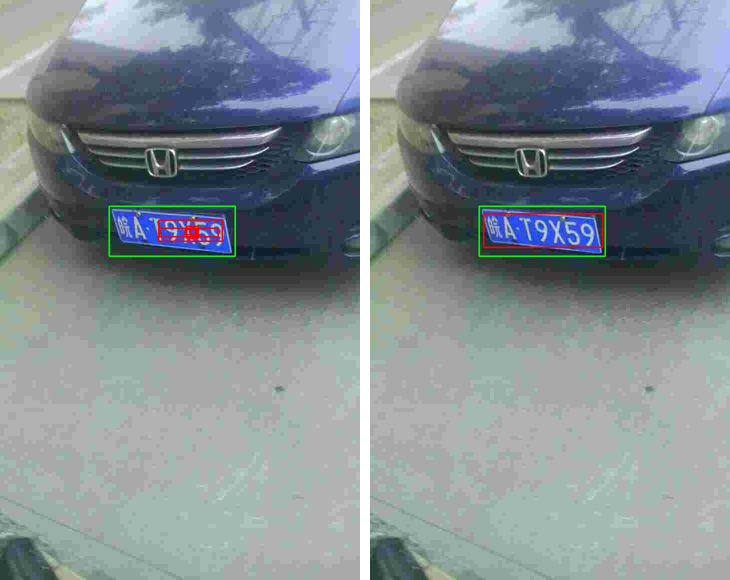

---Overall (Ground-truth vs Pre-trained EAST)---
Precision: 0.0, Recall: 0.0, HMean: 0

---Per Sample Metric---
---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.21
UNMATCHED GT 0 and UNMATCHED PRED 1 IoU: 0.08
UNMATCHED GT 0 and UNMATCHED PRED 2 IoU: 0.01
UNMATCHED GT 0 and UNMATCHED PRED 3 IoU: 0.01
UNMATCHED GT 0 and UNMATCHED PRED 4 IoU: 0.02

---Overall (Ground-truth vs Fine-tuned EAST)---
Precision: 1.0, Recall: 1.0, HMean: 1.0

---Per Sample Metric---
---Matched---
MATCHED GT 0 and MATCHED PRED 0 IoU: 0.63



In [29]:
# Let's visualise the text detection results of ground-truth, pre-trained EAST and fine-tuned EAST
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

pt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_output/vis"
)
ft_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_output/vis"
)
intersect_images = set(os.listdir(pt_path)).intersection(os.listdir(ft_path))
sel_img_id = random.sample(list(intersect_images), 1)[0]
print(f"Visualising result of {sel_img_id}.")

pt_pil_img = Image.open(os.path.join(pt_path, sel_img_id))
img_w, img_h = pt_pil_img.size
new_img_w, new_img_h = int(img_w / 2), int(img_h / 2)
pt_pil_img = pt_pil_img.resize((new_img_w, new_img_h))

ft_pil_img = Image.open(os.path.join(ft_path, sel_img_id))
ft_pil_img = ft_pil_img.resize((new_img_w, new_img_h))

grid_pil_img = Image.new("RGBA", (img_w + 10, new_img_h), (255, 255, 255, 255))
bg_w, bg_h = grid_pil_img.size
grid_pil_img.paste(pt_pil_img, (0, 0))
grid_pil_img.paste(ft_pil_img, (new_img_w + 10, 0))
display(grid_pil_img.convert('RGB'))

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
pt_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_output/east_output.txt"
)
ft_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_output/east_output.txt"
)
gt_dict = txt_to_dict(gt_path, True, sel_img_id=sel_img_id)
pt_det_dict = txt_to_dict(pt_txt_path, False, sel_img_id=sel_img_id)
ft_det_dict = txt_to_dict(ft_txt_path, False, sel_img_id=sel_img_id)

print(f"---Overall (Ground-truth vs Pre-trained EAST)---")
pt_resDict = evaluation(gt_dict, pt_det_dict, eval_config)
precision, recall, hmean = (
    pt_resDict["method"]["precision"],
    pt_resDict["method"]["recall"],
    pt_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(pt_resDict, sel_img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

print(f"---Overall (Ground-truth vs Fine-tuned EAST)---")
ft_resDict = evaluation(gt_dict, ft_det_dict, eval_config)
precision, recall, hmean = (
    ft_resDict["method"]["precision"],
    ft_resDict["method"]["recall"],
    ft_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(ft_resDict, sel_img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)


### Text Recognition

Visualising result of 0102370689655-89_92-314&476_499&548-506&541_311&541_316&478_511&478-0_0_2_20_33_33_26-113-33.jpg.


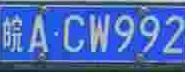

Ground-truth transcription: ACW992
Predicted transcription using pre-trained CRNN: sacw992
Predicted transcription using fine-tuned CRNN: ACW992

---Total Edit Distance (GT vs PT)---
Total Edit Distance: 4
Total Edit Distance (Case Insensitive): 1

---Total Edit Distance (GT vs FT)---
Total Edit Distance: 0
Total Edit Distance (Case Insensitive): 0


In [30]:
# Let's visualise the transcriptions of ground-truth, pre-trained CRNN and fine-tuned CRNN
gt_path = "/content/drive/My Drive/CCPD2019/val_rec.txt"
pt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/crnn_output/crnn_output.txt"
)
ft_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/crnn_output/crnn_output.txt"
)
img_path = "/content/drive/My Drive/CCPD2019/val_crop"
all_images = os.listdir(img_path)
sel_img_id = random.sample(all_images, 1)[0]
print(f"Visualising result of {sel_img_id}.")

gt_trans, pt_trans, ft_trans = vis_rec_res(gt_path, pt_path, ft_path, sel_img_id)

word_pil_img = Image.open(os.path.join(img_path, sel_img_id))
display(word_pil_img)

print(f"Ground-truth transcription: {gt_trans}")
print(f"Predicted transcription using pre-trained CRNN: {pt_trans}")
print(f"Predicted transcription using fine-tuned CRNN: {ft_trans}\n")

print(f"---Total Edit Distance (GT vs PT)---")
total_edit, total_edit_ci = total_edit_distance([gt_trans], [pt_trans])
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}\n")

print(f"---Total Edit Distance (GT vs FT)---")
total_edit, total_edit_ci = total_edit_distance([gt_trans], [ft_trans])
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")


### Text Spotting

Visualising result of 0106609195402-89_84-281&533_461&599-459&593_280&603_277&541_456&531-0_0_26_25_16_24_33-115-39.jpg.


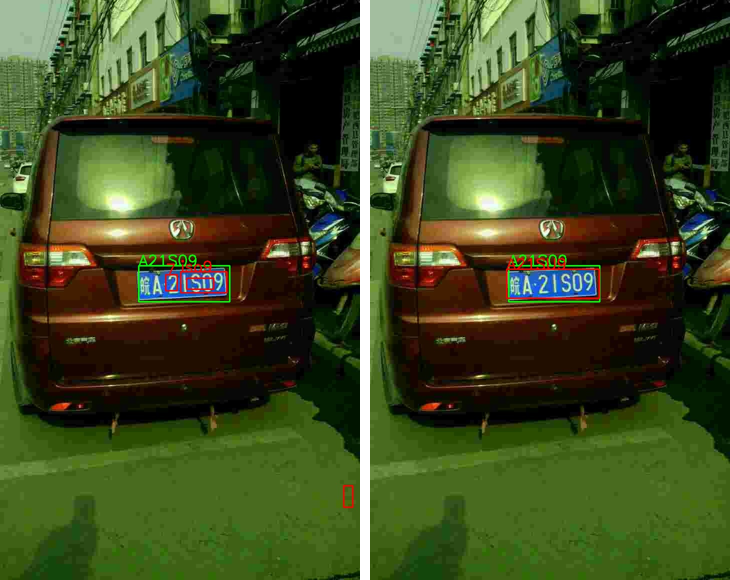

---Overall (Ground-truth vs Pre-trained EAST)---
Precision: 0.0, Recall: 0.0, HMean: 0

---Per Sample Metric---
---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.29
UNMATCHED GT 0 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 0 and UNMATCHED PRED 2 IoU: 0.06
UNMATCHED GT 0 and UNMATCHED PRED 3 IoU: 0.09

---Overall (Ground-truth vs Fine-tuned EAST)---
Precision: 0.0, Recall: 0.0, HMean: 0

---Per Sample Metric---
---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.79



In [31]:
# Let's visualise the text spotting results of ground-truth, pre-trained EAST and fine-tuned EAST
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

pt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output/vis"
)
ft_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output/vis"
)
intersect_images = set(os.listdir(pt_path)).intersection(os.listdir(ft_path))
sel_img_id = random.sample(list(intersect_images), 1)[0]
print(f"Visualising result of {sel_img_id}.")

pt_pil_img = Image.open(os.path.join(pt_path, sel_img_id))
img_w, img_h = pt_pil_img.size
new_img_w, new_img_h = int(img_w / 2), int(img_h / 2)
pt_pil_img = pt_pil_img.resize((new_img_w, new_img_h))

ft_pil_img = Image.open(os.path.join(ft_path, sel_img_id))
ft_pil_img = ft_pil_img.resize((new_img_w, new_img_h))

grid_pil_img = Image.new("RGBA", (img_w + 10, new_img_h), (255, 255, 255, 255))
bg_w, bg_h = grid_pil_img.size
grid_pil_img.paste(pt_pil_img, (0, 0))
grid_pil_img.paste(ft_pil_img, (new_img_w + 10, 0))
display(grid_pil_img.convert('RGB'))

gt_path = "/content/drive/My Drive/CCPD2019/val.txt"
pt_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/pretrained_results/east_crnn_output/east_crnn_output.txt"
)
ft_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 5/"
    "License_Plate_Recognition/finetuned_results/east_crnn_output/east_crnn_output.txt"
)
gt_dict = txt_to_dict(gt_path, True, sel_img_id=sel_img_id)
pt_det_dict = txt_to_dict(pt_txt_path, True, sel_img_id=sel_img_id)
ft_det_dict = txt_to_dict(ft_txt_path, True, sel_img_id=sel_img_id)

print(f"---Overall (Ground-truth vs Pre-trained EAST)---")
pt_resDict = evaluation(gt_dict, pt_det_dict, eval_config)
precision, recall, hmean = (
    pt_resDict["method"]["precision"],
    pt_resDict["method"]["recall"],
    pt_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(pt_resDict, sel_img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

print(f"---Overall (Ground-truth vs Fine-tuned EAST)---")
ft_resDict = evaluation(gt_dict, ft_det_dict, eval_config)
precision, recall, hmean = (
    ft_resDict["method"]["precision"],
    ft_resDict["method"]["recall"],
    ft_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(ft_resDict, sel_img_id)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)


<a name="conclusion"></a>
## Conclusion

In conclusion, this tutorial provided a comprehensive overview of text detection, text recognition, and text spotting using PPOCR, along with the process of fine-tuning. Through our exploration, we demonstrated that fine-tuning offers improved performance compared to using pre-trained models alone. To further assist your understanding, we have compiled a list of Frequently Asked Question(s) below:

1. **When should we use pre-trained models on PaddleOCR?** </br>
   You are encouraged to use pre-trained models when the pre-trained datasets match your target dataset's distribution, representation, and objective. By ensuring the source and target datasets are compatible, the pre-trained models are more likely to yield better results.
   
2. **When should we fine-tune models on PaddleOCR?** </br>
   In most cases, we must fine-tune the models on our target dataset to achieve optimal results, especially when the images in those pre-trained datasets vary hugely against our target dataset. For instance, in the license plate recognition on the CCPD2019 dataset, we already show the effectiveness of fine-tuning.